# Code for AMAS project 2
### *By Niels August Davidsen*

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

# Seed
np.random.seed(42)


In [123]:
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

___

# Problem 1:



In [124]:
def acc_rej(N_points, f, a, b, xrange=[-1.02, 1.11], yrange=[0,2]):
    n=0
    data = []
    while n < N_points:
        x = np.random.uniform(*xrange)
        y = np.random.uniform(*yrange)
        if y < f(x, a,b):
            data.append(x)
            n+=1
    return np.array(data)

def pdf_non_normal(x, a, b):
    return 1 + x * a + b * x**2

x_min = -1.02
x_max = 1.11
a_true = 0.9
b_true = 0.55

def pdf(x, a, b):
    integral, _ = quad(pdf_non_normal, x_min, x_max, args=(a, b))
    A = 1 / integral
    return A * pdf_non_normal(x, a,b)

def llh(params, data):
    return -np.sum(np.log(pdf(data, *params)))

N_points = 807
data = acc_rej(N_points, pdf, a_true, b_true)
np.savetxt("davidsen_polynomial.txt", data)

guess = [0, 0]
res = minimize(llh, x0=guess, args=(data,), method='L-BFGS-B')
a_ml, b_ml = res.x
inv_hess = res.hess_inv.todense()
a_ml_err, b_ml_err = np.sqrt(np.diag(inv_hess))
print(f"Maximum likelihood estimates: a={a_ml:.3f} +/- {a_ml_err:.3f}, b={b_ml:.3f} +/- {b_ml_err:.3f}")


Maximum likelihood estimates: a=0.771 +/- 0.123, b=0.461 +/- 0.305


In [125]:
from scipy.stats import poisson
lam_true = 3.8
Np = 513

data_poisson = poisson.rvs(lam_true, size=Np)
np.savetxt("davidsen_poisson.txt", data_poisson)   
def llh_poisson(lam, data):
    return -np.sum(np.log(poisson.pmf(data, lam)))

guess = [2]
res = minimize(llh_poisson, x0=guess, args=(data_poisson,), method='L-BFGS-B')
lam_ml = res.x[0]
inv_hess = res.hess_inv.todense()
lam_ml_err = np.sqrt(inv_hess[0,0])
print(f"Maximum likelihood estimate: lambda={lam_ml:.3f} +/- {lam_ml_err:.3f}")


Maximum likelihood estimate: lambda=3.667 +/- 0.084


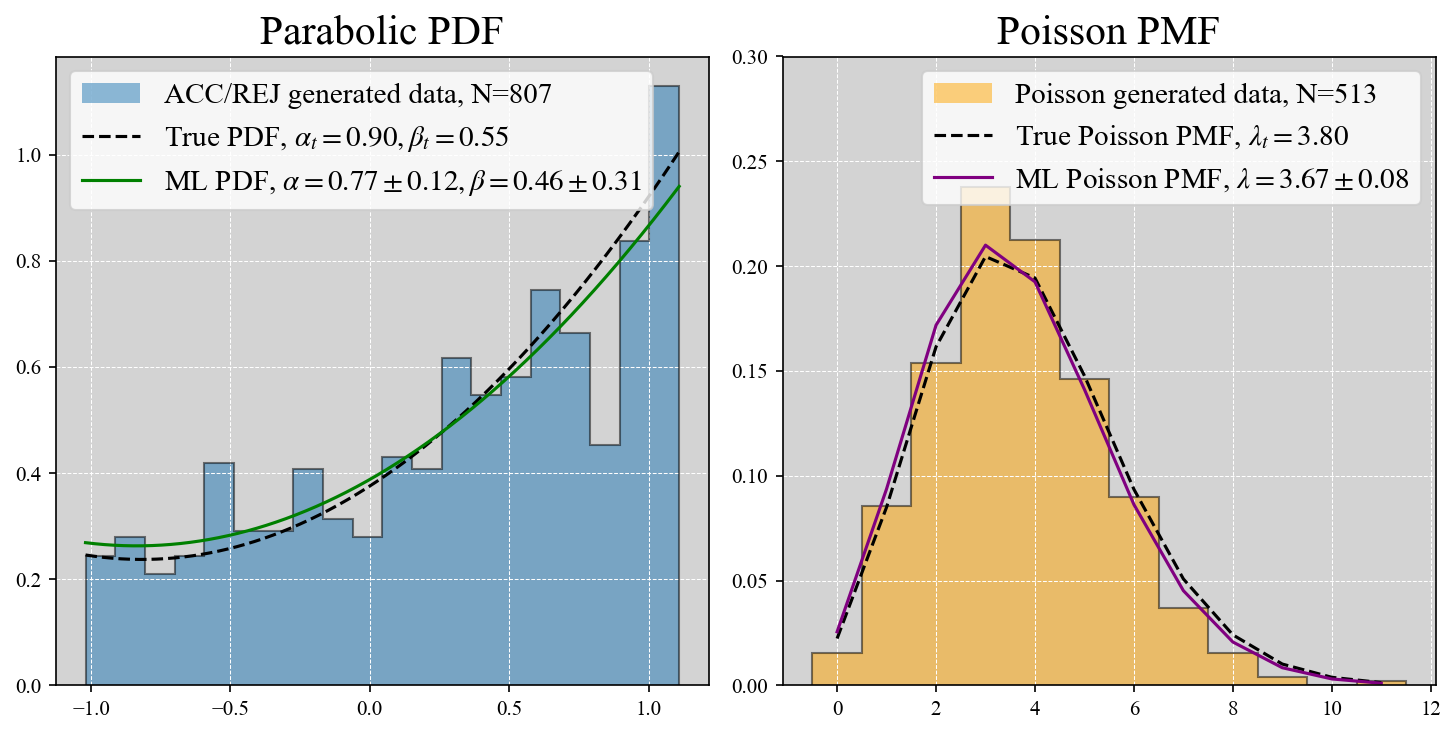

In [126]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
hist_range = [-1.02, 1.11]
ax[0].hist(data, range=hist_range, bins=20, label=f'ACC/REJ generated data, N={len(data)}', alpha=0.5, density=True, histtype='stepfilled');
ax[0].hist(data, range=hist_range, bins=20, alpha=0.5, density=True, histtype='step', color='k');
x = np.linspace(*hist_range, 1000)

ax[0].plot(x, 
           pdf(x, a_true, b_true), 
           label=r'True PDF, $\alpha_t = {:.2f}, \beta_t = {:.2f}$'.format(a_true,  b_true), 
           lw=1.5, 
           color='k', 
           ls='--')

ax[0].plot(x, 
           pdf(x, a_ml, b_ml), 
           label=r'ML PDF, $\alpha = {:.2f} \pm {:.2f}, \beta = {:.2f} \pm {:.2f}$'.format(a_ml, a_ml_err, b_ml, b_ml_err), 
           lw=1.5, color='green', 
           ls='-')
ax[0].set_title('Parabolic PDF', fontsize=20)



hist_range = [-0.5, 11.5]
ax[1].hist(data_poisson, range=hist_range, bins=12, label=f'Poisson generated data, N={len(data_poisson)}', alpha=0.5, density=True, histtype='stepfilled', color='orange');
ax[1].hist(data_poisson, range=hist_range, bins=12, alpha=0.5, density=True, histtype='step', color='k');
x = np.arange(hist_range[0] + 0.5, hist_range[1] + 0.5, 1)
ax[1].plot(x, 
           poisson.pmf(x, lam_true), 
           label=r'True Poisson PMF, $\lambda_t = {:.2f}$'.format(lam_true), 
           lw=1.5, 
           color='k', 
           ls='--')

ax[1].plot(x, poisson.pmf(x, lam_ml), 
           label=r'ML Poisson PMF, $\lambda = {:.2f} \pm {:.2f}$'.format(lam_ml, lam_ml_err), 
           lw=1.5, 
           color='purple', 
           ls='-')

ax[1].set_ylim(0, 0.3)
ax[1].set_title('Poisson PMF', fontsize=20)


for a in ax:
    a.set_facecolor('lightgrey')
    a.grid(color='white', which='both', linestyle='--', lw=0.5) 
    a.legend(fontsize=14)

plt.tight_layout()
plt.savefig("figures/1.png")


___ 

# Problem 2:



In [127]:
from matplotlib.path import Path

In [128]:
boundary_points = np.loadtxt("OutlineAreaSpline.txt", skiprows=1, usecols=(0,1))
x = boundary_points[:,0]
y = boundary_points[:,1]
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

n_inside = []
n_trials = 1000
N_samples = int(1e5)
path = Path(boundary_points, )

for i in range(n_trials):
    
    x_samples = np.random.uniform(x_min, x_max, N_samples)
    y_samples = np.random.uniform(y_min, y_max, N_samples)
    
    inside = path.contains_points(np.column_stack((x_samples, y_samples)))
    x_inside = x_samples[inside]
    y_inside = y_samples[inside]
    x_outside = x_samples[~inside]
    y_outside = y_samples[~inside]

    n_inside.append(len(x_inside))

area_square = (x_max - x_min) * (y_max - y_min)
area = int(np.mean(n_inside)) * area_square / N_samples 



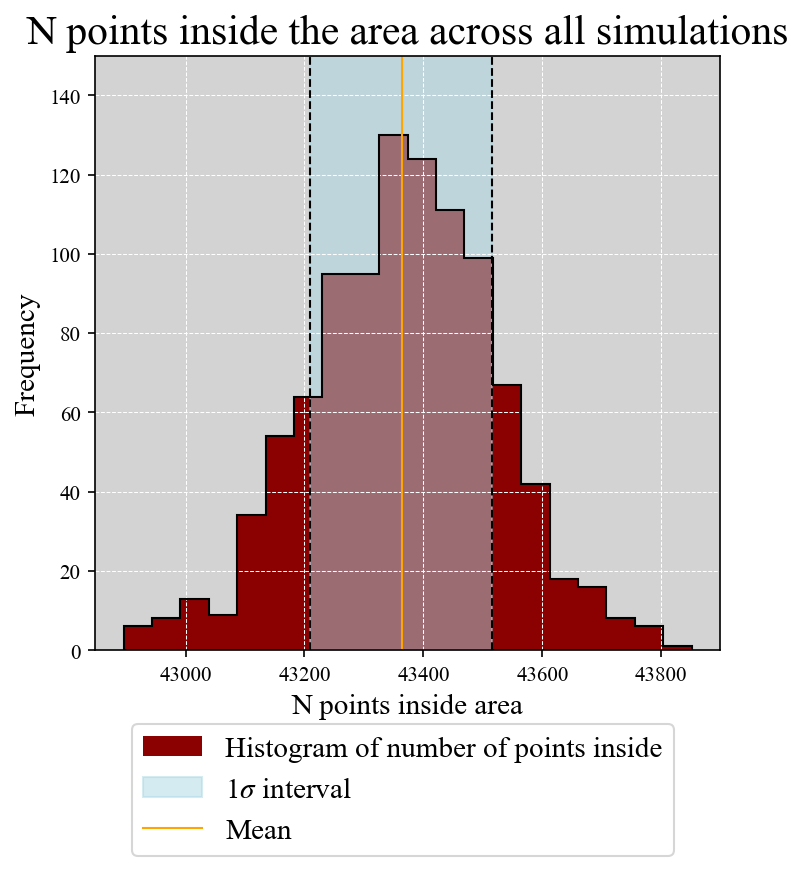

In [129]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.hist(n_inside, bins=20, histtype='stepfilled', alpha=1, label='Histogram of number of points inside', color='darkred');
ax.hist(n_inside, bins=20, histtype='step', alpha=1, color='k');

one_sig_int = np.percentile(n_inside, [50-34.1, 50+34.1])
ax.axvline(one_sig_int[0], color='k', ls='--', linewidth=1)
ax.axvline(one_sig_int[1], color='k', ls='--', linewidth=1)
ax.fill_betweenx([0, 200], one_sig_int[0], one_sig_int[1], color='lightblue', alpha=0.5, label='1$\sigma$ interval')
ax.axvline(int(np.mean(n_inside)), color='orange', ls='-', linewidth=1, label='Mean')
ax.set(ylim=(0, 150))
ax.set_title('N points inside the area across all simulations', fontsize=20)
ax.set_xlabel('N points inside area', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set(facecolor='lightgrey')
ax.grid(color='white', which='both', linestyle='--', lw=0.5)
plt.tight_layout()
ax.legend(fontsize=14, bbox_to_anchor=(0.95,-0.1))


err_plus = (one_sig_int[1] - int(np.mean(n_inside))) * area_square / N_samples
err_minus = (int(np.mean(n_inside) - one_sig_int[0])) * area_square / N_samples

plt.savefig("figures/2_plus.png", bbox_inches='tight')


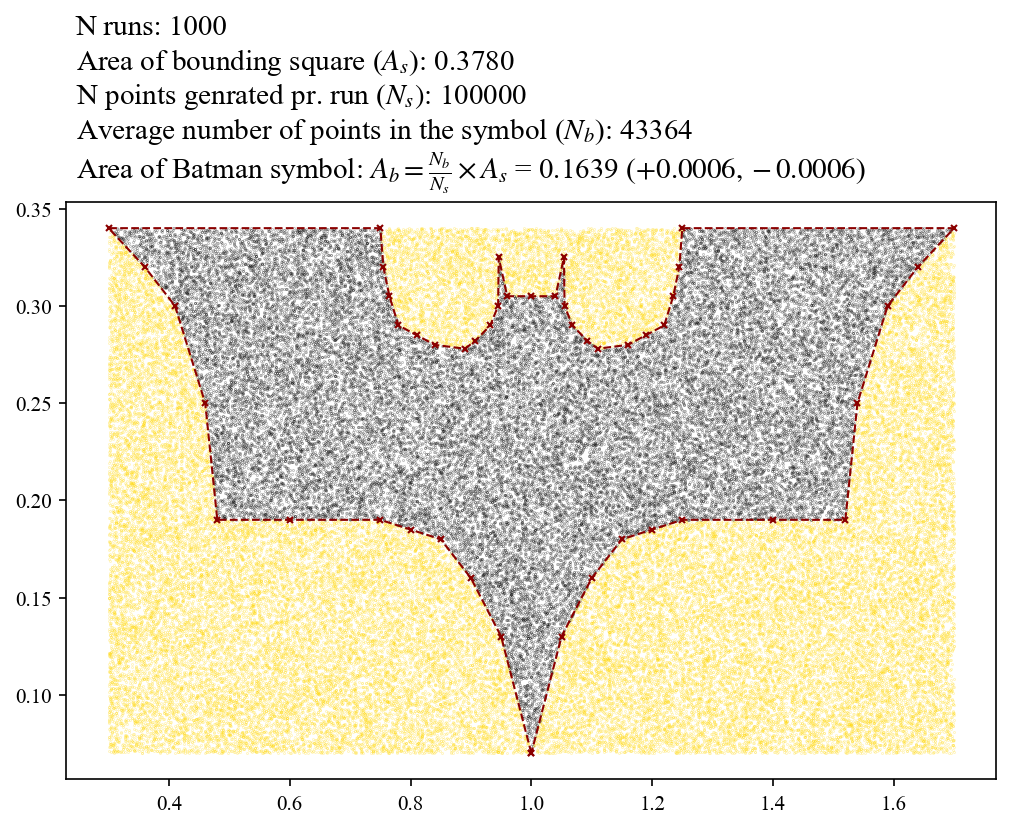

In [130]:

b_area_str = r"Area of Batman symbol: $A_b = \frac{N_b}{N_s} \times A_s$" + f" = {area:.4f} ($+{err_plus:.4f}, -{err_minus:.4f}$)"
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(x_outside, y_outside, color='gold', ls='', marker='o', markersize=.1, label='Points outside the Batman symbol')
ax.plot(x_inside, y_inside, color='k', ls='', marker='o', markersize=.1, label='Points within the Batman symbol')
ax.plot(x, y, color='darkred', ls='--', marker='x', markersize=3, lw='1', label='Boundary of Batman symbol')
ax.text(0.01, 1.29, f"N runs: {n_trials}", transform=ax.transAxes, fontsize=14)
ax.text(0.01, 1.23, f"Area of bounding square ($A_s$): {area_square:.4f}", transform=ax.transAxes, fontsize=14)
ax.text(0.01, 1.17, f"N points genrated pr. run ($N_s)$: {N_samples}", transform=ax.transAxes, fontsize=14)
ax.text(0.01, 1.11, f"Average number of points in the symbol ($N_b$): {int(np.mean(n_inside))}", transform=ax.transAxes, fontsize=14)
ax.text(0.01, 1.04, b_area_str, transform=ax.transAxes, fontsize=14)

#ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

plt.savefig("figures/2.png", bbox_inches='tight')


____ 

# Problem 3:

Suppose that there are genes which are individually ‘x' or ‘X’, and in combination determine some trait, e.g. hair color: xx is red, mixed genes (xX or Xx) are black, and XX is black. 
The population has a proportion of red-haired people equal to $p^2$ and mixed gene people equal to $2p(1-p)$, for $0<p<1$. 

Each parent gives a single gene to their offspring, with a 50:50 probability of x or X for mixed gene parents. 
We can assume a random mixture of parents within the population.

Of children that are xX what is the proportion that come 
come from parents which both have black hair?
Hint this is a conditional probability.



## Using conditional probability

The question posed can also be answered by answering the other question: What is the probability that both parents have black hair, given that the child has the xX gene combination. 
This can be expressed using conditional probability as:

$P(\text{A|B}) = P(\text{Two parents w. black hair | child with xX}) = \frac{\text{Two parents w. black hair \textit{and} child has xX}}{\text{Child has xX}} $

Starting with the numerator, this can be expressed as the sum of probabilities for all combinations of parental genes resulting in black hair times their respective probability of having a child with the xX gene combination:

$P(\text{Two parents w. black hair | child with xX}) =  \frac{1}{2}P(\text{par. w. xX, xX}) + \frac{1}{2}P(\text{par. w. XX, xX}) + 0 P(\text{par. w. XX, XX}) = \frac{1}{2}(2(2p(1-p))^2) + \frac{1}{2}(2(2p(1-p)(1-p)^2)) = 4p^2(1-p)^2 + 2p(1-p)^3 = 2p(1-p)^2(1+p)$


The denominator is likewise the sum of probabilities for ALL combinations of parental genes resulting in a child with the xX gene combination times the probability of having a child with xX genes given the specific parental gene combination.

$P(\text{Child w. xX}) =  1(P(\text{Par. w. xx, XX})) + \frac{1}{2}P(\text{Par. w. xx, xX}) + \frac{1}{2}P(\text{Par. w. xX, xX}) + \frac{1}{2}P(\text{Par. w. XX, xX}) = 1(2p^2(1-p)^2) + \frac{1}{2}(4p^2p(1-p)) + \frac{1}{2}(4p(1-p))^2 + \frac{1}{2}(4p(1-p)(1-p)^2) = 2p(1-p)[1+p-p^2]$ 




# Using Bayes theorem

For this problem i decided to use bayes theorem:


Starting with the likekelihood. In short, this is the probability that the child has xX genes given that both parents have black hair. This can be determined by the sum of the probabilities of both parent having black hair (given som combination of parental genes genes) times the probability of the specific gene combination making a child with the xX gene combination. As both parents have to be black haired this is leaves us with the combinations xX and XX for parent genes. But obviously two parents with the genes XX would have 0\% chance of getting a child with the genes xX so only the combinations (xX, xX) and (XX, xX) are left and these both have 50\% chance of getting a child with genes xX.

The likelihood can be written as

$P(\text{Child w. xX} | \text{Two par. w. black hair}) = P(\text{Child xX | Two Par w. xX, xX}) \times P(\text{Two Par w. black hair}) + P(\text{Child xX |Two Par w. xX, XX}) \times P(\text{Two Par w. xX, XX | Black hair})$

The probabilities $P(\text{Child xX |Two Par w. xX, xX})$ and $P(\text{Child xX |Two Par w. xX, xX})$ are just $50\% = 0.5$ as each parent have a 50/50 chance of passing either gene along.
The probabilities for having specific parental genes given that they have black hair are determined by the the probability of having that specific gene combination divided by the probability of having black hair. So for one parent with xX genes the equation looks like:

$P(\text{Par w. xX} | Black hair) = \frac{P(\text{Par w. xX})}{P(\text{Black hair})} = \frac{2p(1-p)}{1-p^2}$


Then the probability of two parent having xX genes given that they both have black hair is:

$P(\text{Two Par w. xX, xX}| \text{Black hair}) = (\frac{2p(1-p)}{1-p^2})^2$

And the probability of one parent having xX and the other having XX given that they both have black hair is:

$P(\text{Two Par. w. xX, XX}| \text{Black hair}) = 2\frac{2p(1-p)}{1-p^2} \times \frac{(1-p)^2}{1-p^2} = 2 \frac{2p(1-p)^3}{(1-p^2)^2}$

The factor 2 is just a consequence of the fact that the combination (xX, XX) is the same as (XX, xX), 
Finally the likelihood can be written as:

$P(\text{Child w. xX} | \text{Two par. w. black hair}) = \frac{1}{2} (\frac{2p(1-p)}{1-p^2})^2 +  \frac{1}{2} 2 \frac{2p(1-p)^3}{(1-p^2)^2}  = 2p[\frac{(1-p)^2}{(1-p^2)^2}] = \frac{2p}{(p+1)^2}$



The prior $P(\text{a w. b})$ can simply be written as 

$P(\text{Two par. w. Black hair}) = (1-p^2)^2$

as this is the probability of not having red hair squared (two parents).


The marginal probability is the probability of a child having mixed genes, but this is already given by the proportion of the population having mixed genes $p_{mixed} = 2p(1-p)$


Finally the posterior is found to be:

$P(\text{Two par. w. black hair | Childe w. xX}) = \frac{\frac{2p}{(p+1)^2} \times (1-p^2)^2}{2p(1-p)} = 1-p$

Which is just a negative linear slope with an offset.



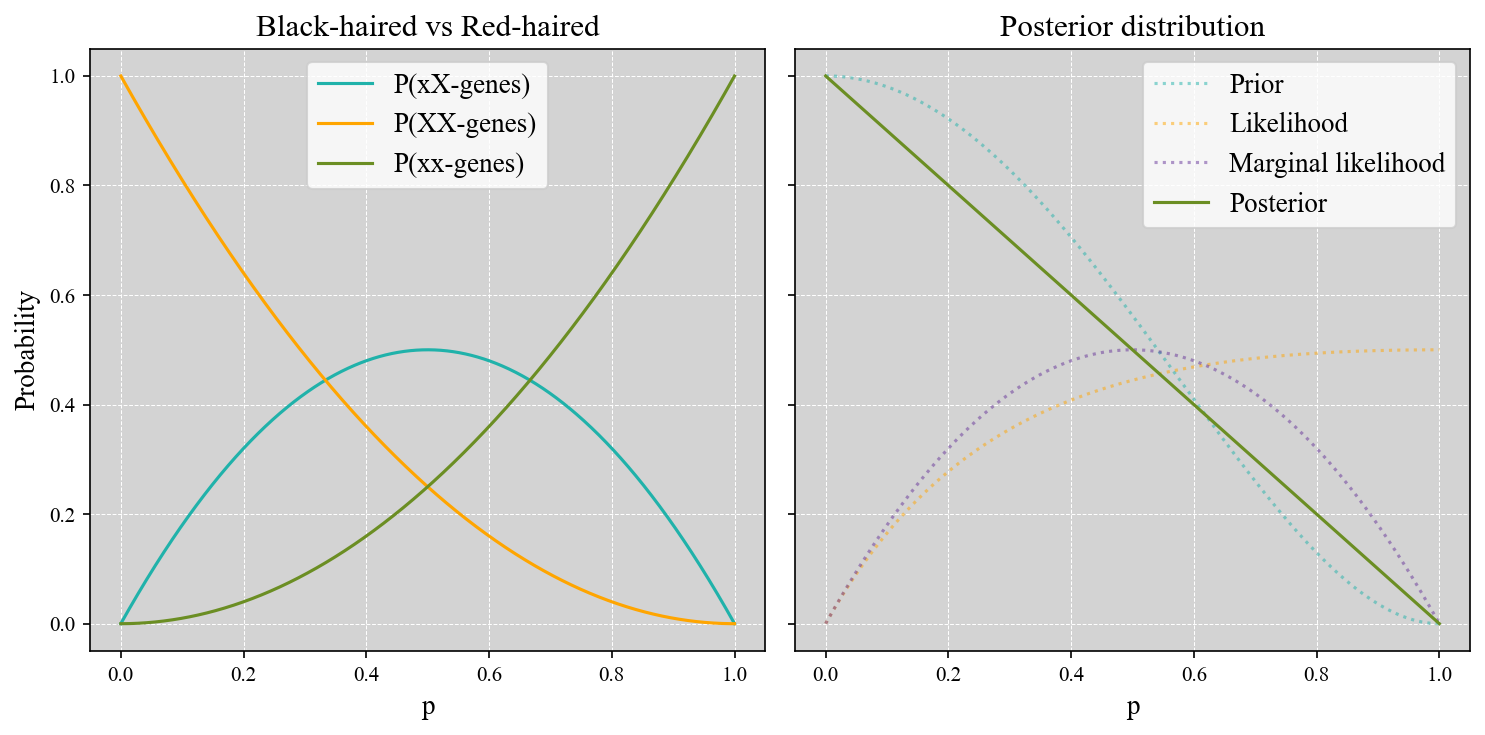

In [131]:
p = np.linspace(0.0001, 0.9999, 1000)

mixed_genes = 2*p*(1-p)
big_genes = (1-p)**2
small_genes = p**2 

def prior(p):
    return (1-p**2)**2

def marginal_likelihood():
    return mixed_genes

def likelihood(p):
    return 2*p/ (1+p)**2

def posterior(p):
    return likelihood(p) * prior(p) / marginal_likelihood()



fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150, sharey=True)



ax[0].plot(p, mixed_genes, label='P(xX-genes)', color='lightseagreen')
ax[0].plot(p, big_genes, label='P(XX-genes)', color='orange')
ax[0].plot(p, small_genes, label='P(xx-genes)', color='olivedrab')
ax[0].set_xlabel('p', fontsize=13)
ax[0].set_ylabel('Probability', fontsize=13)
ax[0].set_title('Black-haired vs Red-haired', fontsize=15)

ax[1].plot(p, prior(p), label='Prior', color='lightseagreen', ls=':', alpha=0.5)
ax[1].plot(p, likelihood(p), label='Likelihood', color='orange', ls=':', alpha=0.5)
ax[1].plot(p, marginal_likelihood(), label='Marginal likelihood', color='rebeccapurple', ls=':', alpha=0.5)
ax[1].plot(p, posterior(p), label='Posterior', color='olivedrab')
ax[1].set_xlabel('p', fontsize=13)
ax[1].set_title('Posterior distribution', fontsize=15)


for a in ax:
    a.legend(fontsize=13)
    a.set_facecolor('lightgrey')
    a.grid(color='white', which='both', linestyle='--', lw=0.5)


plt.tight_layout()
plt.savefig("figures/3a.png")


## Problem 3.b

A person (parent A) that does have black hair and has 
parents w/ black hair produces N offspring w/ someone 
(parent B) that is known to have a xX gene combination. 
What is the posterior probability that parent A has a xX 
gene combination?

* All offspring have black hair 
* The ordering of gene pairs is irrelevant
* Hint: "chain rule"



In [132]:
def prob_collected(p, N):
    p_b1_a = 1-p        # Posterior from before
    p_b2_a = (3/4)**N
    p_a = 2*p / (1+p)
    p_b1_not_a = 1
    p_b2_not_a = 1**N   # 1^N = 1
    p_not_a = 1 - p_a   # (1-p) / (1+p) 

    posterior = p_a * p_b1_a * p_b2_a / (p_a * p_b1_a * p_b2_a + p_not_a * p_b1_not_a * p_b2_not_a)
    return posterior



For this question I used Bayes theorem with multiple conditions ($B_1, B_2$):

$P(A|B_1, B_2) = \frac{P(B_1, B_2|A)P(A)}{P(B_1, B_2)} = \frac{P(B_1|A)P(B_2|A)P(A)}{P(B_1|A)P(B_2|A)P(A) + P(B_1|A^c)P(B_2|A^c)P(A^c)}$

where

* $A$ = Parent A having genes xX
* $A^c$ = Parent A \textit{not} having xX (having XX)
* $B_1$ = Parents of parent A having black hair
* $B_2$ = Parent A and Parent B having N black haired kids

I have decided against putting the derivations of all the terms into this pdf, but i hav put the analytical expression for each team into the table shown in (ref):


The final expression for the posterior probability distribution is

$P(A|B_1, B_2) = \frac{(1-p) (3/4)^N \frac{2p}{p+1}}{(1-p) (3/4)^N \frac{2p}{p+1} + \frac{1-p}{1+p}} = \frac{(3/4)^N 2p}{(3/4)^N 2p+ 1} = \frac{1}{1+\frac{1}{2p(3/4)^N}}$








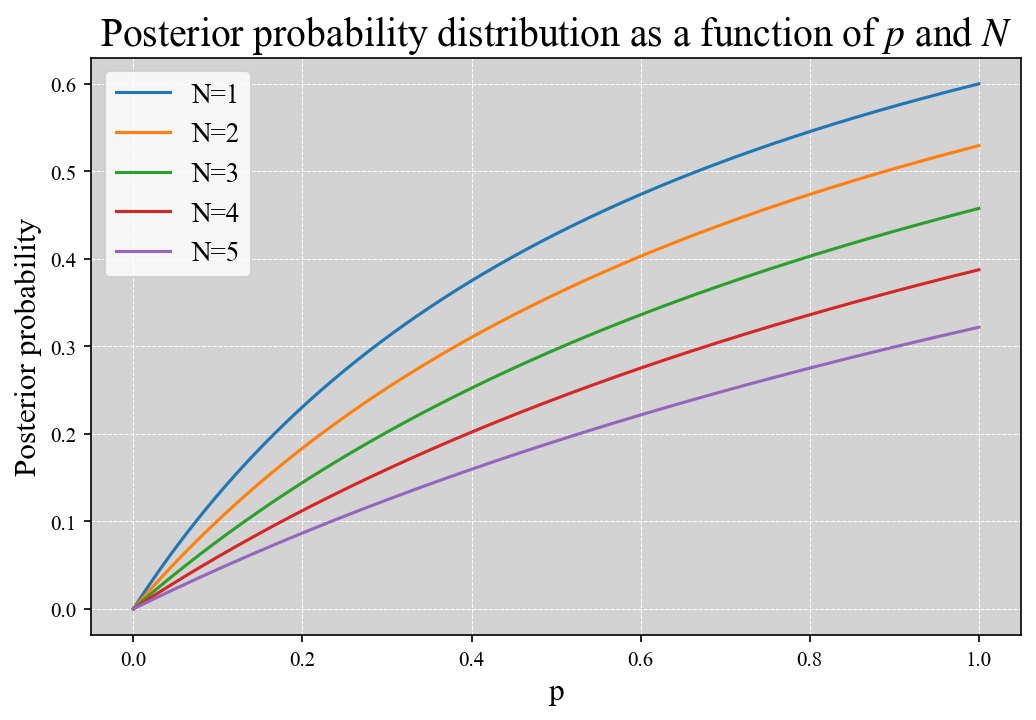

In [133]:
p = np.linspace(0.0001, 0.9999, 1000)
N = np.arange(1, 6)

fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
for n in N:
    ax.plot(p, prob_collected(p, n), label=f'N={n}')

ax.set_xlabel('p', fontsize=15)
ax.set_ylabel('Posterior probability', fontsize=15)
ax.set_title(r'Posterior probability distribution as a function of $p$ and $N$', fontsize=19)
ax.legend(fontsize=13)
ax.set_facecolor('lightgrey')
ax.grid(color='white', which='both', linestyle='--', lw=0.5)


plt.savefig("figures/3b.png")


____

# Exercise 4

In [134]:
lake_mu = 5000
lake_sigma = 300
fish_mu = 10
fish_sigma = 1

N_samples = int(1e5)
boot_samples = 1000
mean_vals = []

for i in range(boot_samples):
    fish_values = np.random.normal(fish_mu, fish_sigma, N_samples)
    lake_values = np.random.normal(lake_mu, lake_sigma, N_samples)
    fish_population = lake_values / fish_values
    mean_pop = int(np.mean(fish_population))
    mean_vals.append(mean_pop)


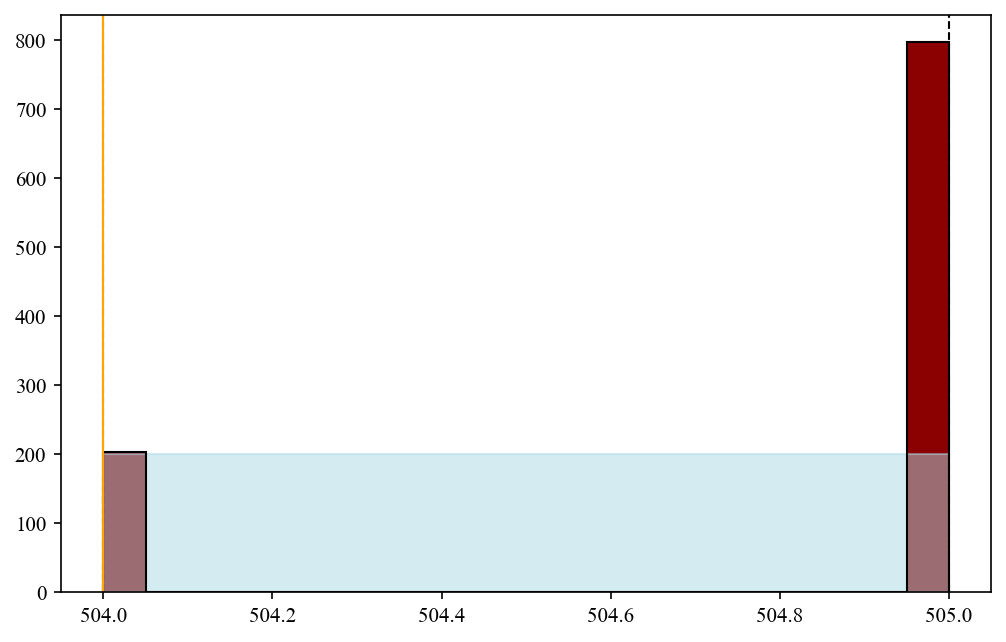

In [135]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.hist(mean_vals, bins=20, histtype='stepfilled', alpha=1, label='Histogram of mean values', color='darkred');
ax.hist(mean_vals, bins=20, histtype='step', alpha=1, color='k');

one_sig_int = np.percentile(mean_vals, [50-34.1, 50+34.1])
ax.axvline(one_sig_int[0], color='k', ls='--', linewidth=1)
ax.axvline(one_sig_int[1], color='k', ls='--', linewidth=1)
ax.fill_betweenx([0, 200], one_sig_int[0], one_sig_int[1], color='lightblue', alpha=0.5, label='1$\sigma$ interval')
ax.axvline(int(np.mean(mean_vals)), color='orange', ls='-', linewidth=1, label='Mean')

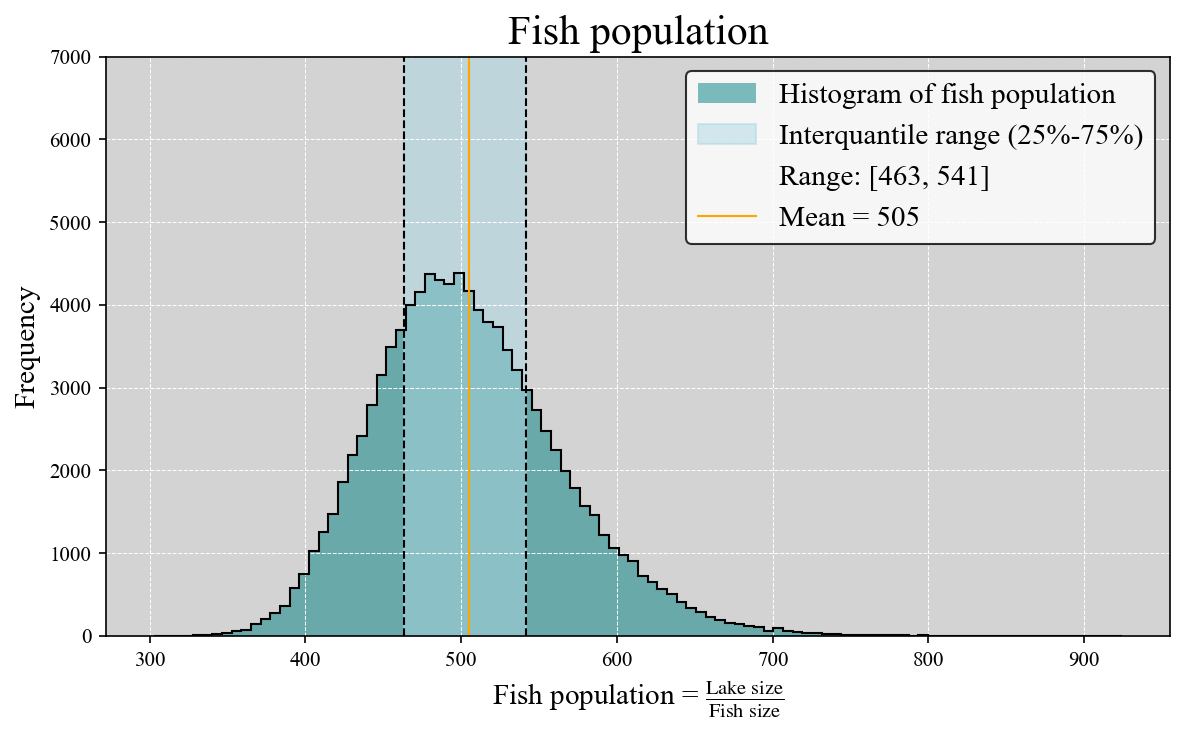

In [136]:

fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.hist(fish_population, bins=100, histtype='stepfilled', alpha=0.5, label='Histogram of fish population', color='teal');
ax.hist(fish_population, bins=100, histtype='step', alpha=1, color='k');

interquantile = np.percentile(fish_population, [25, 75])
int_quart_range = [int(interquantile[0]), int(interquantile[1])]
ax.axvline(interquantile[0], color='k', ls='--', linewidth=1) 
ax.axvline(interquantile[1], color='k', ls='--', linewidth=1)
ax.fill_betweenx([0, 7000], interquantile[0], interquantile[1], color='lightblue', alpha=0.5, label='Interquantile range (25%-75%)')
ax.fill_betweenx([0, 7000], interquantile[0], interquantile[1], color='white', alpha=0, label='Range: [{}, {}]'.format(int_quart_range[0], int_quart_range[1]))
ax.axvline(np.mean(fish_population), color='orange', ls='-', linewidth=1, label='Mean = {:.0f}'.format(int(mean_pop)))

ax.set_title('Fish population', fontsize=20)
ax.set_xlabel(r'Fish population = $\frac{\text{Lake size}}{\text{Fish size}}$', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set(facecolor='lightgrey')
ax.grid(color='white', which='both', linestyle='--', lw=0.5)
# Give legend a black outline

ax.legend(fontsize=14, edgecolor='k')


ax.set(ylim=(0, 7000 ))
plt.tight_layout()
plt.savefig("figures/4.png", bbox_inches='tight')